In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import shutil
import json
import pandas as pd
import kagglehub

In [2]:
path = kagglehub.dataset_download("apollo2506/eurosat-dataset")
print("Dataset downloaded to:", path)

# Define paths (assuming files are in the root directory)
data_dir = os.path.join(path, "EuroSAT")  # Directory with image subdirectories
label_map_path = os.path.join(data_dir, "label_map.json")  # Root directory
train_csv_path = os.path.join(data_dir, "train.csv")       # Root directory
test_csv_path = os.path.join(data_dir, "test.csv")         # Root directory
validation_csv_path = os.path.join(data_dir, "validation.csv")  # Root directory

if not os.path.exists(label_map_path):
    raise FileNotFoundError(f"label-map.json not found at {label_map_path}")
if not os.path.exists(train_csv_path):
    raise FileNotFoundError(f"train.csv not found at {train_csv_path}")
if not os.path.exists(test_csv_path):
    raise FileNotFoundError(f"test.csv not found at {test_csv_path}")
if not os.path.exists(validation_csv_path):
    raise FileNotFoundError(f"validation.csv not found at {validation_csv_path}")

Dataset downloaded to: /kaggle/input/eurosat-dataset


In [3]:
with open(label_map_path, 'r') as f:
    label_map = json.load(f)
print("Label map:", label_map)

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
validation_df = pd.read_csv(validation_csv_path)

# Inspect the first few rows of each CSV
print("\nTrain CSV head:")
print(train_df.head())
print("\nTest CSV head:")
print(test_df.head())
print("\nValidation CSV head:")
print(validation_df.head())

# Construct full file paths
def get_full_path(row):
    class_name = row['ClassName']
    filename = row['Filename']
    file_name_only = filename.split('/')[-1]
    return os.path.join(data_dir, class_name, file_name_only)

train_df['file_path'] = train_df.apply(get_full_path, axis=1)
test_df['file_path'] = test_df.apply(get_full_path, axis=1)
validation_df['file_path'] = validation_df.apply(get_full_path, axis=1)

# Map labels to numerical values if necessary
if train_df['Label'].dtype == object:
    train_df['Label'] = train_df['Label'].map(label_map)
    test_df['Label'] = test_df['Label'].map(label_map)
    validation_df['Label'] = validation_df['Label'].map(label_map)

Label map: {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}

Train CSV head:
   Unnamed: 0                                           Filename  Label  \
0       16257                      AnnualCrop/AnnualCrop_142.jpg      0   
1        3297  HerbaceousVegetation/HerbaceousVegetation_2835...      2   
2       17881               PermanentCrop/PermanentCrop_1073.jpg      6   
3        2223                      Industrial/Industrial_453.jpg      4   
4        4887  HerbaceousVegetation/HerbaceousVegetation_1810...      2   

              ClassName  
0            AnnualCrop  
1  HerbaceousVegetation  
2         PermanentCrop  
3            Industrial  
4  HerbaceousVegetation  

Test CSV head:
   Unnamed: 0                          Filename  Label    ClassName
0        2438    AnnualCrop/AnnualCrop_1275.jpg      0   AnnualCrop
1        1018   Residential/Residential_504.jp

In [4]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32

# Function to load and preprocess an image
def load_and_preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = image / 255.0
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_df['file_path'].values, train_df['Label'].values)
)
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (validation_df['file_path'].values, validation_df['Label'].values)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['file_path'].values, test_df['Label'].values)
)

# Map the preprocessing function
train_dataset = train_dataset.map(
    load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE
)
validation_dataset = validation_dataset.map(
    load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE
)
test_dataset = test_dataset.map(
    load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE
)

# Batch and optimize
train_dataset = train_dataset.batch(BATCH_SIZE).shuffle(1000).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify the datasets
for image_batch, label_batch in train_dataset.take(1):
    print("Train image batch shape:", image_batch.shape)
    print("Train label batch shape:", label_batch.shape)

for image_batch, label_batch in validation_dataset.take(1):
    print("Validation image batch shape:", image_batch.shape)
    print("Validation label batch shape:", label_batch.shape)

for image_batch, label_batch in test_dataset.take(1):
    print("Test image batch shape:", image_batch.shape)
    print("Test label batch shape:", label_batch.shape)

Train image batch shape: (32, 64, 64, 3)
Train label batch shape: (32,)
Validation image batch shape: (32, 64, 64, 3)
Validation label batch shape: (32,)
Test image batch shape: (32, 64, 64, 3)
Test label batch shape: (32,)


Inverse label map: {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway', 4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop', 7: 'Residential', 8: 'River', 9: 'SeaLake'}
Class: River (Label: 8)


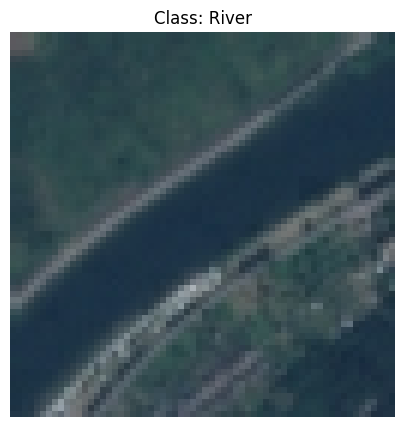

In [5]:
label_map = {'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 
             'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}
# Invert the dictionary: {0: 'AnnualCrop', 1: 'Forest', ...}
inverse_label_map = {v: k for k, v in label_map.items()}
print("Inverse label map:", inverse_label_map)

# Step 2: Extract a random image and label from the training dataset
# Unbatch the dataset to work with individual samples
train_dataset_unbatched = train_dataset.unbatch()

# Shuffle and take 1 random sample
random_sample = train_dataset_unbatched.shuffle(buffer_size=1000).take(1)

# Step 3: Get the image and label
for image, label in random_sample:
    image = image.numpy()  # Convert Tensor to NumPy array for plotting
    label = label.numpy()  # Convert Tensor to NumPy array

# Step 4: Get the class name from the label
class_name = inverse_label_map[label]
print(f"Class: {class_name} (Label: {label})")

# Step 5: Display the image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.title(f"Class: {class_name}")
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [6]:
def residual_block(x, filters, downsample=False):
    identity = x
    
    if downsample or identity.shape[-1] != filters:
        identity = layers.Conv2D(filters, kernel_size=1, 
                                 strides=2 if downsample else 1, 
                                 padding="same")(identity)
        identity = layers.BatchNormalization()(identity)
    
    x = layers.Conv2D(filters, kernel_size=3, 
                      strides=2 if downsample else 1, 
                      padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding="same")(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Add()([x, identity])
    x = layers.ReLU()(x)
    
    return x

def ResNet18(input_shape=(64, 64, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)
    
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    
    x = residual_block(x, 128, downsample=True)
    x = residual_block(x, 128)
    
    x = residual_block(x, 256, downsample=True)
    x = residual_block(x, 256)
    
    x = residual_block(x, 512, downsample=True)
    x = residual_block(x, 512)
    
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    model = Model(inputs, outputs, name="ResNet-18")
    return model

# Create the model
num_classes = 10
model = ResNet18(input_shape=(64, 64, 3), num_classes=num_classes)
model.summary()

Model: "ResNet-18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32, 32, 64)     │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 32, 32, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 16, 16, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 16, 16, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 16, 16, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,196,042 (42.71 MB)

 Trainable params: 11,186,442 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [7]:
class WarmupCallback(tf.keras.callbacks.Callback):
    def __init__(self, warmup_epochs, initial_lr, target_lr):
        super(WarmupCallback, self).__init__()
        self.warmup_epochs = warmup_epochs
        self.initial_lr = initial_lr
        self.target_lr = target_lr
        self.step = (target_lr - initial_lr) / warmup_epochs

    def on_epoch_begin(self, epoch, logs=None):
        if epoch < self.warmup_epochs:
            new_lr = self.initial_lr + self.step * epoch
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"Epoch {epoch+1}: Setting learning rate to {new_lr:.6f}")

In [8]:
def model_training(model, train_data, test_data, epochs=100, learning_rate=0.001):
    checkpoint = ModelCheckpoint(
        "EuroSAT_resnet.keras",
        monitor='val_accuracy',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='max'
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_accuracy',  
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1,
        mode='max'
    )

    warmup = WarmupCallback(warmup_epochs=5, initial_lr=0.0001, target_lr=learning_rate)
    
    # Compile model
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    
    # Train model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=test_data,
        callbacks=[checkpoint, early_stopping, reduce_lr]
    )

    results = model.evaluate(test_dataset, verbose=0)

    print(f"----------------------")
    print(f"Test Loss: {results[0]:.4f}")
    print(f"Test Accuracy: {results[1]:.4f}")
    
    return history, results

In [9]:
history_1, result_1 = model_training(model=model, train_data=train_dataset, test_data=validation_dataset, epochs=20)

Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.5292 - loss: 1.4185
Epoch 1: val_accuracy improved from -inf to 0.43648, saving model to EuroSAT_resnet.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.5293 - loss: 1.4180 - val_accuracy: 0.4365 - val_loss: 2.5306 - learning_rate: 0.0010
Epoch 2/20
589/591 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7113 - loss: 0.7995
Epoch 2: val_accuracy did not improve from 0.43648
591/591 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7114 - loss: 0.7993 - val_accuracy: 0.2270 - val_loss: 4.4204 - learning_rate: 0.0010
Epoch 3/20
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7763 - loss: 0.6316
Epoch 3: val_accuracy improved from 0.43648 to 0.59296, saving model to EuroSAT_resnet.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.7763 - loss: 0.6316 - val_accuracy: 0.5930 - val_loss: 1.2968 - learning_rate: 0.0010
Epoch 4/20
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8147 - lo

In [10]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


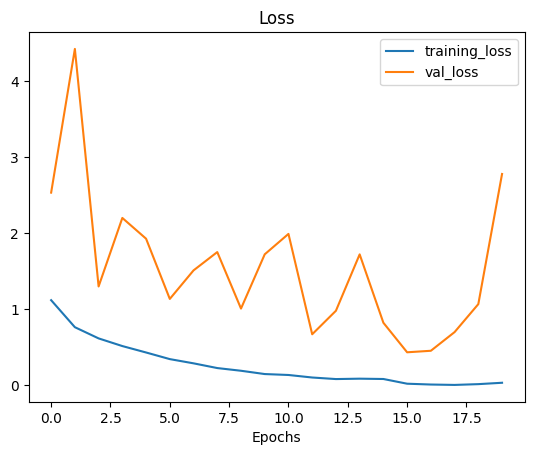

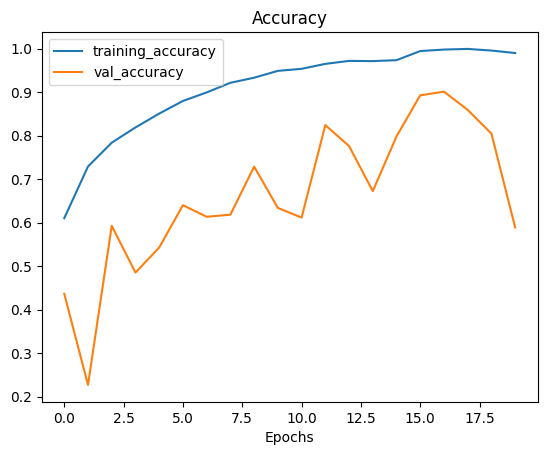

In [11]:
plot_loss_curves(history_1)

In [12]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    if tf.random.uniform([]) > 0.5:  # Rotate 50% of the time
        image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

train_augmented_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

In [13]:
history_2, results_2 = model_training(model=model, train_data=train_augmented_dataset, test_data=validation_dataset, epochs=20)

Epoch 1/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8956 - loss: 0.3660
Epoch 1: val_accuracy improved from -inf to 0.70907, saving model to EuroSAT_resnet.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 46s 39ms/step - accuracy: 0.8956 - loss: 0.3659 - val_accuracy: 0.7091 - val_loss: 1.1601 - learning_rate: 0.0010
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9140 - loss: 0.2601
Epoch 2: val_accuracy did not improve from 0.70907
591/591 ━━━━━━━━━━━━━━━━━━━━ 22s 25ms/step - accuracy: 0.9140 - loss: 0.2601 - val_accuracy: 0.6237 - val_loss: 1.6863 - learning_rate: 0.0010
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9275 - loss: 0.2173
Epoch 3: val_accuracy improved from 0.70907 to 0.80815, saving model to EuroSAT_resnet.keras
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.9275 - loss: 0.2173 - val_accuracy: 0.8081 - val_loss: 0.6513 - learning_rate: 0.0010
Epoch 4/20
590/591 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9203 - lo

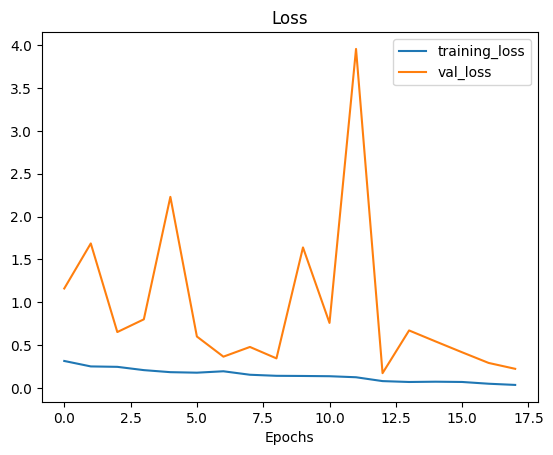

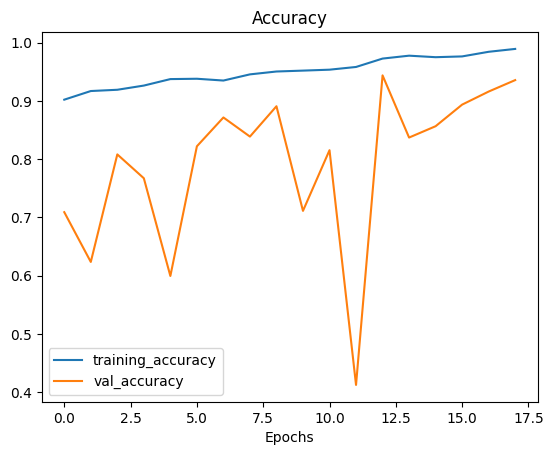

In [14]:
plot_loss_curves(history_2)